Epoch 0: Accuracy 0.000, Average Loss 2.3025196194648743
Epoch 0: Accuracy 0.000, Average Loss 2.302444410324097

Epoch 1: Accuracy 0.355, Average Loss 1.237639699379603
Epoch 1: Accuracy 0.534, Average Loss 0.825426173210144

Epoch 2: Accuracy 0.733, Average Loss 0.6338689347108205
Epoch 2: Accuracy 0.848, Average Loss 0.38998043090105056

Epoch 3: Accuracy 0.871, Average Loss 0.33960477660099664
Epoch 3: Accuracy 0.924, Average Loss 0.21734325289726258

Epoch 4: Accuracy 0.918, Average Loss 0.2284044772386551
Epoch 4: Accuracy 0.951, Average Loss 0.14475975781679154

Epoch 5: Accuracy 0.939, Average Loss 0.17388475338617962
Epoch 5: Accuracy 0.960, Average Loss 0.11417592465877532

Epoch 6: Accuracy 0.947, Average Loss 0.1534255358080069
Epoch 6: Accuracy 0.964, Average Loss 0.10294567048549652

Epoch 7: Accuracy 0.949, Average Loss 0.14622526640693348
Epoch 7: Accuracy 0.961, Average Loss 0.10481693521142006

Epoch 8: Accuracy 0.957, Average Loss 0.1207367009172837
Epoch 8: Accuracy

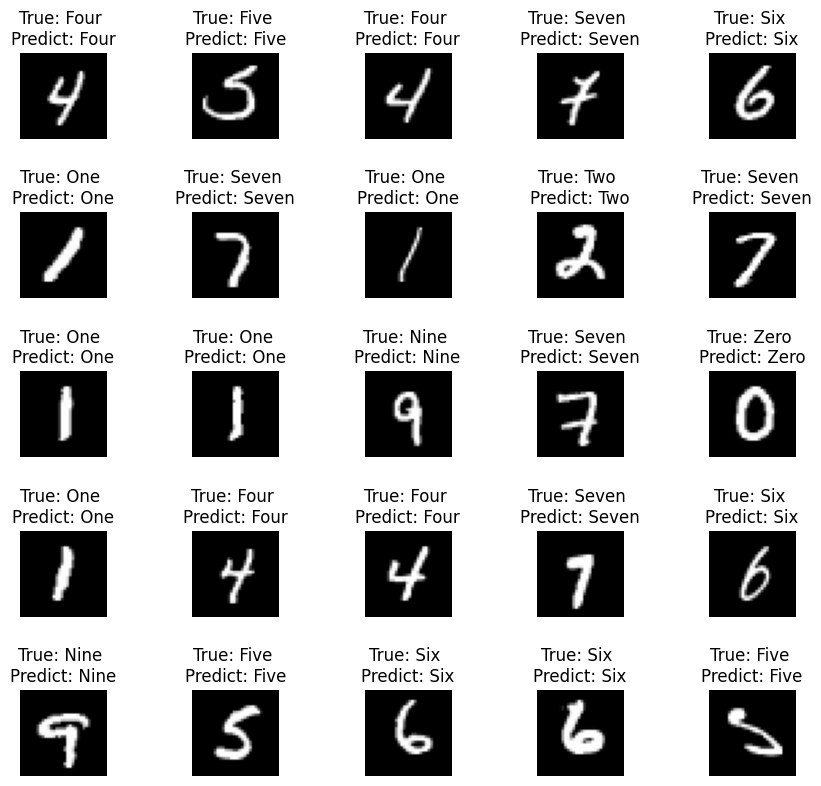

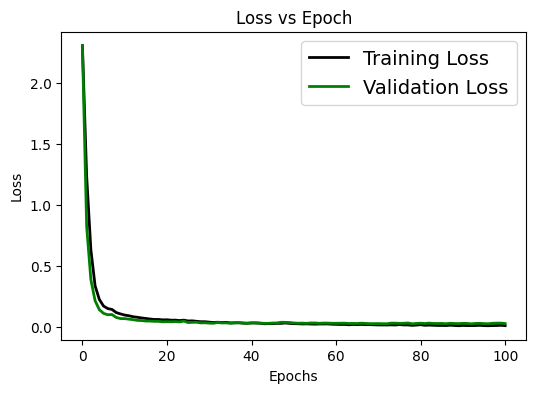

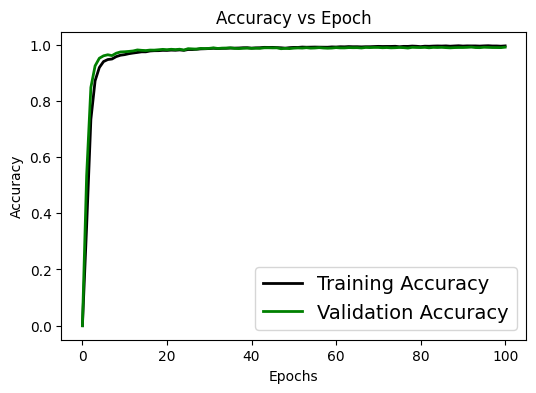

In [2]:
# train the model

import os
import sys

import numpy as np
import mlx.core as mx
import matplotlib.pyplot as plt
from PIL import Image

from softgrad import Network
from softgrad.layer.transform import Flatten
from softgrad.optim import SGD
from softgrad.function.activation import leaky_relu, softmax
from softgrad.function.loss import CrossEntropyLoss, cross_entropy_loss
from softgrad.layer.core import Linear, Activation

sys.path.append(os.path.abspath('..'))
from util.dataset import get_mnist


# Visualize
def viz_sample_predictions(network, test_data, label_map, rows=5, cols=5, figsize=(10, 10)):
    fig, axes = plt.subplots(rows, cols, figsize=figsize, num="Sample Predictions")
    axes = axes.reshape(-1)  # flatten

    test_data = test_data.to_buffer().shuffle()
    def sample_random():
        for j in np.arange(0, rows * cols):
            i = np.random.randint(0, len(test_data))
            x = mx.array(test_data[i]['image'])
            y = mx.array(test_data[i]['label'])
            y_pred = network.forward(x[mx.newaxis, ...])

            sample = np.array(255 * x)
            if sample.shape[2] == 3:
                image = Image.fromarray(sample.astype('uint8'))
            else:
                image = Image.fromarray(sample.reshape(sample.shape[0], sample.shape[1]))

            raw_label = mx.argmax(y).item()
            label = label_map[raw_label]

            raw_pred = mx.argmax(y_pred).item()
            pred = label_map[raw_pred]

            axes[j].imshow(image)
            axes[j].set_title(f"True: {label} \nPredict: {pred}")
            axes[j].axis('off')
            plt.subplots_adjust(wspace=1)

    def on_key(event):
        if event.key == ' ':
            sample_random()
            fig.show()

    fig.canvas.mpl_connect('key_press_event', on_key)

    sample_random()


def viz_history(history, figsize=(6, 4)):
    plt.figure(figsize=figsize, num="Loss Curves")
    plt.plot(history['epoch'], history['train_loss'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_loss'], 'green', linewidth=2.0)
    plt.legend(['Training Loss', 'Validation Loss'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Loss', fontsize=10)
    plt.title('Loss vs Epoch', fontsize=12)

    plt.figure(figsize=figsize, num="Accuracy Curves")
    plt.plot(history['epoch'], history['train_accuracy'], 'black', linewidth=2.0)
    plt.plot(history['epoch'], history['test_accuracy'], 'green', linewidth=2.0)
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=14)
    plt.xlabel('Epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.title('Accuracy vs Epoch', fontsize=12)


# Evaluate
def eval_model(model, dataset, epoch=None):
    mean_losses = []
    accuracies = []
    predictions = []

    for batch in dataset:
        x_batch = mx.array(batch["image"])
        y_batch = mx.array(batch["label"])

        y_pred = model.forward(x_batch)
        predictions.append(y_pred)

        loss = optimizer.loss_fn(y_pred, y_batch)
        mean_loss = mx.mean(mx.sum(loss, axis=1))
        mean_losses.append(mean_loss.item())

        if isinstance(optimizer.loss_fn, CrossEntropyLoss):
            y_pred = softmax(y_pred)

        errors = mx.sum(mx.abs(y_batch - mx.round(y_pred)), axis=1)
        accuracy = mx.sum(errors == 0) / y_batch.shape[0]
        accuracies.append(accuracy.item())

    mean_loss = sum(mean_losses) / len(mean_losses)
    accuracy = sum(accuracies) / len(accuracies)
    predictions = np.concatenate(predictions)

    dataset.reset()

    if epoch is not None:
        print(f"Epoch {epoch}: Accuracy {accuracy:.3f}, Average Loss {mean_loss}")
    else:
        print(f"Accuracy {accuracy:.3f}, Average Loss {mean_loss}")

    return predictions, accuracy, mean_loss


def train(train_data, epochs, batch_size=1, test_data=None, cb=None):
    batched_train_data = train_data.batch(batch_size)
    batched_test_data = test_data.batch(batch_size)

    def train_epoch():
        for batch in batched_train_data:
            x_batch = mx.array(batch["image"])
            y_batch = mx.array(batch["label"])
            optimizer.step(x_batch, y_batch)
        batched_train_data.reset()

    history = {"epoch": [], "train_loss": [], "test_loss": [], "train_accuracy": [], "test_accuracy": []}

    _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=0)
    _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=0)
    print()
    history["epoch"].append(0)
    history["train_loss"].append(train_loss)
    history["test_loss"].append(test_loss)
    history["train_accuracy"].append(train_accuracy)
    history["test_accuracy"].append(test_accuracy)

    for epoch in range(1, epochs + 1):
        train_epoch()

        _, train_accuracy, train_loss = eval_model(network, batched_train_data, epoch=epoch)
        _, test_accuracy, test_loss = eval_model(network, batched_test_data, epoch=epoch)
        print()
        history["epoch"].append(epoch)
        history["train_loss"].append(train_loss)
        history["test_loss"].append(test_loss)
        history["train_accuracy"].append(train_accuracy)
        history["test_accuracy"].append(test_accuracy)

    test_data.reset()
    eval_model(network, batched_test_data)
    print()

    viz_sample_predictions(network, test_data, label_map)
    viz_history(history)
    plt.show()


train_data, test_data = get_mnist(static=False)
label_map = ["Zero", "One", "Two", "Three", "Four", "Five", "Six", "Seven", "Eight", "Nine"]

network = Network(input_shape=(32, 32, 1))

# feed forward 1
network.add_layer(Flatten())
network.add_layer(Linear(1024))
network.add_layer(Activation(leaky_relu))
# feed forward 2
network.add_layer(Linear(512))
network.add_layer(Activation(leaky_relu))
# feed forward 3
network.add_layer(Linear(256))
network.add_layer(Activation(leaky_relu))
# output
network.add_layer(Linear(10))

optimizer = SGD(eta=0.05, momentum=0.9, weight_decay=0.0005)
optimizer.bind_loss_fn(cross_entropy_loss)
optimizer.bind_network(network)

train(train_data, epochs=100, batch_size=1000, test_data=test_data)